In [1]:
#Packages
import os
import pyspark
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.functions import col, sqrt,sum,avg,count,explode,max as _max, min as _min,round,trim
from operator import add
import time
import json
from datetime import datetime
from dateutil.relativedelta import relativedelta
from pyspark.sql.window import Window
from pyspark.sql import functions as f
from pyspark.sql.types import ArrayType
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from datetime import datetime, timedelta
import calendar

In [63]:
spark.stop()

In [2]:
conf = pyspark.SparkConf().setAll([('spark.executor.memory', '15g'), 
                                   ('spark.executor.instances', '30'),
                                   ('spark.driver.cores','1'), 
                                   ('spark.executor.cores', '4'), 
                                   ('spark.sql.broadcastTimeout', '36000'),
                                   ('spark.sql.autoBroadcastJoinThreshold','1048576000'),
                                   ('spark.yarn.queue', 'root.araadh_q1.uhc_oa_pi_dev_sq1'),
                                   ('spark.driver.memory','18g')])
spark = SparkSession.builder.appName("Model-C").config(conf=conf).enableHiveSupport().getOrCreate().newSession()
spark

# Files Paths

In [3]:
base_data_path = "/datalake/uhc/ei/pi_ara/sherlock/datasource/hive/pi_prod/PCM/837p_all_columns"
timed_cpt_path = "/datalake/uhc/ei/pi_ara/kappa/users/aaiman/HBP_Exclusions/CPT_Billing_Minutes_06NOV19.csv"
filters_path = "/datalake/uhc/ei/pi_ara/kappa/users/aaiman/HBP_Exclusions/exclusions.csv"
em_codes_path = "/datalake/uhc/ei/pi_ara/kappa/users/skapoo10/Sherlock_PCM_Redevelopment/Documents/EM_Upcoding/EM_CPT_Upcoding.csv"

# Parameters

In [4]:
max_leads_hnp = -1
min_pat_cnt = 51
max_leads_hsd =-1
min_dos_cnt= 354
lag=3

# Base Data Preparation

In [5]:

#837 data
base_data = spark.read.parquet(base_data_path)
base_data.createOrReplaceTempView("base_data")


data = spark.sql("""
select srk_clm_id, substring(srk_clm_id,1,26) as claim_number, invn_ctl_nbr, prov_mpin_id,
       clm_bill_prov_tin, clm_bill_prov_npi, cl_ref_prov_npi, cl_prim_care_prov_npi,clm_bill_prov_entity_type, cl_rend_prov_npi, clm_rend_prov_npi,
       cl_facility_state, clm_facility_state, clm_bill_prov_state,fln_nbr,
       (case when trim(cl_rend_prov_npi)!='' then cl_rend_prov_npi 
       when trim(cl_rend_prov_npi)='' and trim(clm_rend_prov_npi)='' then clm_bill_prov_npi 
       when trim(cl_rend_prov_npi)='' then clm_rend_prov_npi end) as prov_npi, 
       (case when trim(cl_facility_state)!='' then cl_facility_state 
       when trim(cl_facility_state)='' and trim(clm_facility_state)='' then clm_bill_prov_state 
       when trim(cl_facility_state)='' then clm_facility_state end) as facility_state, 
       (case when trim(cl_facility_city)!='' then cl_facility_city 
       when trim(cl_facility_city)='' and trim(clm_facility_city)='' then clm_bill_prov_city 
       when trim(cl_facility_city)='' then clm_facility_city end) as facility_city,     
       (case when trim(cl_facility_zip)!='' then cl_facility_zip 
       when trim(cl_facility_zip)='' and trim(clm_facility_zip)='' then clm_bill_prov_zip 
       when trim(cl_facility_zip)='' then clm_facility_zip end) as facility_zip,
       clm_prov_prtcp_cd, clm_rend_prov_taxonomy_cd, cl_rend_prov_taxonomy_cd, clm_bill_prov_tax_cd, 
       (case when trim(cl_rend_prov_taxonomy_cd)!='' then cl_rend_prov_taxonomy_cd 
       when trim(clm_rend_prov_taxonomy_cd)!='' then clm_rend_prov_taxonomy_cd
       when trim(cl_rend_prov_npi)='' and trim(clm_rend_prov_npi)='' then clm_bill_prov_tax_cd end) as prov_taxonomy, clm_ref_prov_npi, clm_prim_care_prov_npi, clm_facility_npi,
       clm_subs_entity_type, clm_subs_id,clm_sys_id,
       cl_place_of_srcv, clm_place_of_srcv,
       (case when trim(cl_place_of_srcv)!='' then cl_place_of_srcv else clm_place_of_srcv end) as place_of_service,
       clm_patient_ind_rel_cd, clm_patient_dob, clm_patient_gender, clm_patient_id, clm_patient_l_nm, clm_patient_f_nm, clm_patient_m_nm, 
       clm_total_charge, clm_freq_type_code, clm_delay_rsn_cd, clm_measurement_unit,clm_payer_nm,clm_payer_id,
       clm_hc_diag_type1, clm_hc_diag_code1, clm_hc_diag_type2, clm_hc_diag_code2, clm_hc_diag_type3, clm_hc_diag_code3, clm_hc_diag_type4, clm_hc_diag_code4, clm_hc_diag_type5, clm_hc_diag_code5, clm_hc_diag_type6, clm_hc_diag_code6, clm_hc_diag_type7, clm_hc_diag_code7, clm_hc_diag_type8, clm_hc_diag_code8, clm_hc_diag_type9, clm_hc_diag_code9, clm_hc_diag_type10, clm_hc_diag_code10, clm_hc_diag_type11, clm_hc_diag_code11, clm_hc_diag_type12, clm_hc_diag_code12,
       cl_proc_cd_type, cl_proc_cd, cl_proc_mod1, cl_proc_mod2, cl_proc_mod3, cl_proc_mod4, cl_line_item_chrg_amt, cl_measurement_code, cl_units_billed, cl_fst_serv_dt, cl_lst_serv_dt, batch_run_dt
from base_data
where trim(clm_freq_type_code) = 1
""")
data.createOrReplaceTempView("data")


em_codes = spark.read.csv(em_codes_path,header=True)
em_codes.createOrReplaceTempView("em_codes")

data_v2 = data.withColumn("proc_mod_cd_concat", 
                                    f.concat(f.lit(' '),
                                             f.col('cl_proc_mod1'),
                                             f.lit(' '),
                                             f.col('cl_proc_mod2'),
                                             f.lit(' '),
                                             f.col('cl_proc_mod3'),
                                             f.lit(' '),
                                             f.col('cl_proc_mod4'),
                                             f.lit(' '),))

data_v2.createOrReplaceTempView("data_v2")



In [6]:
data_v3 = spark.sql("""
select a.*, c.entity_type, c.primary_taxonomy,get_json_object(c.json_data,"$.provider_first_name") as fname,
get_json_object(c.json_data,"$.provider_middle_name") as mname,
get_json_object(c.json_data,"$.provider_last_name") as lname,
(case when trim(a.prov_taxonomy)!='' then a.prov_taxonomy else c.primary_taxonomy end) as prov_taxonomy_final,
(case when b.CPT is not null then 1 else 0 end) as em_flag,
(case when b.CPT is not null and suspicious = 'Y' then 1 else 0 end) as upcoded_em_flag,
(case when proc_mod_cd_concat like '%25%' then 1 else 0 end) as mod25_flag,
(case when b.CPT is not null and proc_mod_cd_concat like '%25%' then 1 else 0 end) as em_mod25_flag,
(case when b.CPT is not null and suspicious = 'Y' and proc_mod_cd_concat like '%25%' then 1 else 0 end) as upcoded_em_mod25_flag,
coalesce(suspicious,"NA") as suspicious 
from data_v2 as a
left join em_codes as b
on trim(a.cl_proc_cd)=(b.cpt)
left join pi_prod.nppes as c
on trim(a.prov_npi)=trim(c.npi)
""")
data_v3 = data_v3.fillna("",subset=["fname","mname","lname"])
data_v3 = data_v3.withColumn("provider_name",concat_ws(" ",trim(data_v3["fname"]),trim(data_v3["mname"]),trim(data_v3["lname"])))
data_v3 = data_v3.drop("fname","mname","lname")
data_v3.createOrReplaceTempView("data_v3")


# Utility Functions

# Filters

 Exclusions                     HNP   HSD     Explantion

Remote CPT,POS & Modifiers       Y     Y      Remote services will account for high patients and service days

Pathology CPT,POS & Modifiers    Y     Y      As sample testing is not time consuming they can have both high number of                                                       patients and service days

Chronic Care Management CPT      Y     Y      Because they can be provided both remotely and in-office they should be excluded

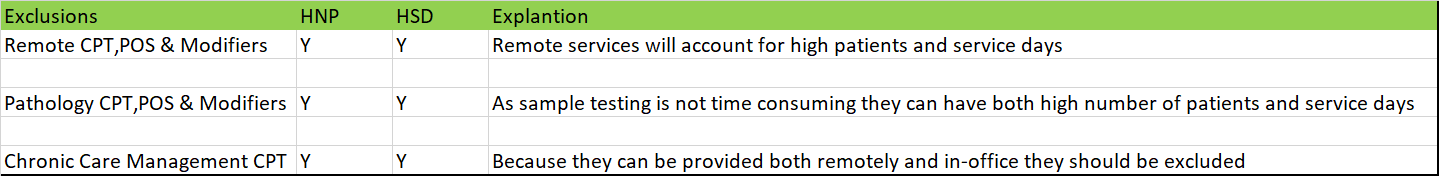

Timed cpt filter

In [7]:
timed_cpt = spark.read.csv(timed_cpt_path,header=True)
timed_cpt = timed_cpt.withColumn("len_cpt", length(trim(f.col("cpt_code"))))
timed_cpt = timed_cpt.filter((col("Total_time")>0) & (f.col("len_cpt")==5))
timed_cpt.createOrReplaceTempView("timed_cpt")

data_v3 = spark.sql("select a.*, (case when b.Total_time >0 then 0 else 1 end) as timed_cpt_flag from data_v3 as a left join timed_cpt as b on a.cl_proc_cd = b.cpt_code")
data_v3.createOrReplaceTempView("data_v3")


In [8]:
#Utility Functions
def calculateStart(replaceDay, relativeMonth):
    if(relativeMonth != ''):
        return (max_date.replace(day = replaceDay) + relativedelta(months = relativeMonth)).strftime("%Y%m%d")
    else:
        return max_date.replace(day = replaceDay).strftime("%Y%m%d")
    
def sql_dos_pat_cnt(sm,cnt,std,tm_prd):
    
    if (sm):
        query = "sum(case when cl_fst_serv_dt " + eval(tm_prd) + " then pat_cnt end) as N_" + tm_prd + "_PatCnt, "
        return query
    elif (cnt):
        query = "count(case when cl_fst_serv_dt " + eval(tm_prd) + " then cl_fst_serv_dt end) as N_" + tm_prd + "_DOSCnt, "
        return query
    elif (std):
        query = "std(case when cl_fst_serv_dt " + eval(tm_prd) + " then pat_cnt end) as N_" + tm_prd + "_Std, "
        return query
    else:
        query = "avg(case when cl_fst_serv_dt " + eval(tm_prd) + " then pat_cnt end) as N_" + tm_prd + "_Avg,"
        return query
    

HBP_select_query = "select a.prov_npi, a.entity_type,  "
HBP_from_query = " from npi_dos_pat a inner join npi_sel b on a.prov_npi = b.prov_npi group by a.prov_npi,a.entity_type "  

srk_max_dt = spark.sql("select max(batch_run_dt) as maxDate from data").collect()[0][0]

max_date = datetime(year=int(srk_max_dt[0:4]), month=int(srk_max_dt[4:6]), day=int(srk_max_dt[6:8]))
print(max_date)

_, num_days = calendar.monthrange(max_date.year, max_date.month)

P3M_ed = P6M_ed = P9M_ed =P12M_ed= (max_date.replace(day = num_days) + relativedelta(months=-lag)).strftime("%Y%m%d")
P3M_sd = calculateStart(1, -(2+lag))
P6M_sd = calculateStart(1, -(5+lag))
P9M_sd = calculateStart(1, -(8+lag))
P12M_sd = calculateStart(1,-(11+lag))

P3M = 'between ' + P3M_sd + ' and ' + P3M_ed
P6M = 'between ' + P6M_sd + ' and ' + P6M_ed
P9M = 'between ' + P9M_sd + ' and ' + P9M_ed
P12M = 'between ' + P12M_sd + ' and ' + P12M_ed
print("P3M: ",P3M)
print("P6M: ",P6M)
print("P9M: ",P9M)
print("P12M: ",P12M)

2021-01-31 00:00:00
P3M:  between 20200801 and 20201031
P6M:  between 20200501 and 20201031
P9M:  between 20200201 and 20201031
P12M:  between 20191101 and 20201031


In [19]:
lag =0
P3M_ed = P6M_ed = P9M_ed =P12M_ed= (max_date.replace(day = num_days) + relativedelta(months=-lag)).strftime("%Y%m%d")
P3M_sd = calculateStart(1, -(2+lag))
P6M_sd = calculateStart(1, -(5+lag))
P9M_sd = calculateStart(1, -(8+lag))
P12M_sd = calculateStart(1,-(11+lag))

P3M = 'between ' + P3M_sd + ' and ' + P3M_ed
P6M = 'between ' + P6M_sd + ' and ' + P6M_ed
P9M = 'between ' + P9M_sd + ' and ' + P9M_ed
P12M = 'between ' + P12M_sd + ' and ' + P12M_ed
print("P3M: ",P3M)
print("P6M: ",P6M)
print("P9M: ",P9M)
print("P12M: ",P12M)

P3M:  between 20201101 and 20210131
P6M:  between 20200801 and 20210131
P9M:  between 20200501 and 20210131
P12M:  between 20200201 and 20210131


Universal Filters

In [10]:
#Exclusions flat file
exclusions = spark.read.csv(filters_path,header=True)
exclusions.createOrReplaceTempView("exclusions")

#Types of exclusions for e.g. cpt,pos etc.
exclusion_types = exclusions.select("type").distinct()
exclusion_types = [str(row.type) for row in exclusion_types.collect()]
print("exclusion_types:",exclusion_types)

exclusion_flag_query =""
exclusion_join_query=""

# This loop creates certain parts of sql query which are subsequently added in exlcusion_sql_query to create a final query
for i in exclusion_types:
    exclusion_df = exclusions.filter(f.col("type")==i)
    col_837p = exclusion_df.select("col_837p").distinct()
    col_837p = [str(row.col_837p) for row in col_837p.collect()]
    col_837p = col_837p[0]
    j=str(i)+"_alias"
    flag_name = i+"_flag"
    if i=="mod":
        exclusion_flag_query = exclusion_flag_query+ "(case when "+str(j)+".values is NULL then 0 else 1 end) as "+ str(flag_name)+" , "
        exclusion_join_query = exclusion_join_query+" left join (select * from exclusions where type== "+"'"+str(i)+"'"+") as "+str(j)+" on (trim( " +"a."+str(col_837p) +"1"+" )"+ " = " +"trim("+str(j)+".values) or trim( "+"a."+str(col_837p) +"2"+" )"+ " = " +"trim("+str(j)+".values) or trim( " +"a."+str(col_837p) +"3"+" )"+ " = " +"trim("+str(j)+".values) or trim( " +"a."+str(col_837p) +"4"+" )"+ " = " +"trim("+str(j)+".values))"
    else:
        exclusion_flag_query = exclusion_flag_query+ "(case when "+str(j)+".values is NULL then 0 else 1 end) as "+ str(flag_name)+" , "
        exclusion_join_query = exclusion_join_query+" left join (select * from exclusions where type== "+"'"+str(i)+"'"+") as "+str(j)+" on trim( " +"a."+str(col_837p)+" )"+ " = " +"trim("+str(j)+".values) "
    

temp_query = ''
for i in exclusion_types:
    temp_query = temp_query +" and " +i+"_flag "+ "=0"    

exclusion_sql_query = "select a.* , "+exclusion_flag_query[0:len(exclusion_flag_query)-2]+" from data_v3 as a "+exclusion_join_query
print("exclusion sql query\n",exclusion_sql_query,"\n")



exclusion_types: ['pos', 'cpt', 'mod']
exclusion sql query
 select a.* , (case when pos_alias.values is NULL then 0 else 1 end) as pos_flag , (case when cpt_alias.values is NULL then 0 else 1 end) as cpt_flag , (case when mod_alias.values is NULL then 0 else 1 end) as mod_flag  from data_v3 as a  left join (select * from exclusions where type== 'pos') as pos_alias on trim( a.place_of_service ) = trim(pos_alias.values)  left join (select * from exclusions where type== 'cpt') as cpt_alias on trim( a.cl_proc_cd ) = trim(cpt_alias.values)  left join (select * from exclusions where type== 'mod') as mod_alias on (trim( a.cl_proc_mod1 ) = trim(mod_alias.values) or trim( a.cl_proc_mod2 ) = trim(mod_alias.values) or trim( a.cl_proc_mod3 ) = trim(mod_alias.values) or trim( a.cl_proc_mod4 ) = trim(mod_alias.values)) 



# Patient Count &  DOS Count

In [11]:
#Creating new dataframe- data_v4-that contains data_v3 and exclusion flags
data_v4 = spark.sql(exclusion_sql_query)
data_v4.createOrReplaceTempView("data_v4")

# Calculating patients per day and the number of service days in the last 12 months for a provider
temp_query = ''
for i in exclusion_types:
    temp_query = temp_query +" and " +i+"_flag "+ "=0"
pat = "select prov_npi, entity_type,provider_name,cl_fst_serv_dt,count(distinct clm_patient_id) as pat_cnt from data_v4 where entity_type = 1 and timed_cpt_flag=0 and cl_fst_serv_dt "+P12M+temp_query+" group by prov_npi,entity_type,provider_name,cl_fst_serv_dt"
dos = "select prov_npi,entity_type,provider_name,count(distinct(cl_fst_serv_dt)) as dos_cnt_P12M from data_v4 where entity_type = 1 and timed_cpt_flag=0 and cl_fst_serv_dt "+P12M+temp_query+" group by prov_npi,entity_type,provider_name"

#print("patient sql query\n",query)
pat = spark.sql(pat)
dos = spark.sql(dos)
a=pat.alias('a')
b=dos.alias('b')

npi_dos_pat = a.join(b,a.prov_npi==b.prov_npi,how='inner').select('a.*','b.DOS_CNT_P12M')

npi_dos_pat = npi_dos_pat.withColumn("pat_cnt_flag",when(col("pat_cnt")>=51,1).otherwise(0))

npi_dos_pat.createOrReplaceTempView("npi_dos_pat")

In [59]:
npi_dos_pat.show(truncate=False)

+----------+-----------+--------------+--------------+-------+------------+------------+
|prov_npi  |entity_type|provider_name |cl_fst_serv_dt|pat_cnt|DOS_CNT_P12M|pat_cnt_flag|
+----------+-----------+--------------+--------------+-------+------------+------------+
|1003014028|1          |AMY DIANE HART|20200722      |1      |21          |0           |
|1003014028|1          |AMY DIANE HART|20200307      |1      |21          |0           |
|1003014028|1          |AMY DIANE HART|20200819      |1      |21          |0           |
|1003014028|1          |AMY DIANE HART|20200912      |1      |21          |0           |
|1003014028|1          |AMY DIANE HART|20200610      |1      |21          |0           |
|1003014028|1          |AMY DIANE HART|20200926      |1      |21          |0           |
|1003014028|1          |AMY DIANE HART|20200401      |1      |21          |0           |
|1003014028|1          |AMY DIANE HART|20200624      |1      |21          |0           |
|1003014028|1        

In [12]:
#Applying Exclusion on data_v4
data_v5 = spark.sql("select * from data_v4 where entity_type = 1 and timed_cpt_flag=0 "+temp_query)
data_v5.createOrReplaceTempView("data_v5")

# HNP-LEAD GENERATION

In [13]:
#Parameters
max_leads_hnp = -1
min_pat_cnt = 51
max_leads_hsd =-1
min_dos_cnt= 354

Count of dos where patient count is more than 51

In [14]:
npi_pat_cnt_51 = spark.sql("""
select prov_npi,provider_name,entity_type,sum(pat_cnt_flag) as pat_cnt_51
from npi_dos_pat
group by prov_npi,provider_name,entity_type
""")
npi_pat_cnt_51.createOrReplaceTempView("npi_pat_cnt_51")

In [14]:
#This code creates a sql query to select the leads after applying universal filters of patient count per day and number of leads
q=""

if ((max_leads_hnp != -1) & (min_pat_cnt != -1)):
    a= " and pat_cnt >= " + str(min_pat_cnt)
    b= "limit " + str(max_leads_hnp)
    q="SELECT prov_npi as prov_npi_hnp,provider_name as provider_name_hnp,dos_cnt_P12M as dos_cnt_P12M_hnp, MAX(pat_cnt) AS max_pat_hnp FROM npi_dos_pat where cl_fst_serv_dt "+P12M + a +" GROUP BY prov_npi,provider_name,dos_cnt_P12M ORDER BY max_pat_hnp DESC " + b
elif ((max_leads_hnp != -1) & (min_pat_cnt == -1)):
    a=""
    b= "limit " + str(max_leads_hnp)
    q="SELECT prov_npi as prov_npi_hnp,provider_name as provider_name_hnp,dos_cnt_P12M as dos_cnt_P12M_hnp, MAX(pat_cnt) AS max_pat_hnp FROM npi_dos_pat where cl_fst_serv_dt "+P12M + a +" GROUP BY prov_npi,provider_name,dos_cnt_P12M ORDER BY max_pat_hnp DESC " + b
elif ((max_leads_hnp == -1) & (min_pat_cnt != -1)): 
    a= " and pat_cnt >= " + str(min_pat_cnt)
    b=""
    q="SELECT prov_npi as prov_npi_hnp,provider_name as provider_name_hnp,dos_cnt_P12M as dos_cnt_P12M_hnp, MAX(pat_cnt) AS max_pat_hnp FROM npi_dos_pat where cl_fst_serv_dt "+P12M + a +" GROUP BY prov_npi,provider_name,dos_cnt_P12M ORDER BY max_pat_hnp DESC " + b
else:
    a=""
    b=""
    q="SELECT prov_npi as prov_npi_hnp,provider_name as provider_name_hnp,dos_cnt_P12M as dos_cnt_P12M_hnp, MAX(pat_cnt) AS max_pat_hnp FROM npi_dos_pat where cl_fst_serv_dt "+P12M + a +" GROUP BY prov_npi,provider_name,dos_cnt_P12M ORDER BY max_pat_hnp DESC " + b

print(q)

npi_selected_hnp = spark.sql(q)


npi_selected_hnp.createOrReplaceTempView("npi_selected_hnp")

SELECT prov_npi as prov_npi_hnp,provider_name as provider_name_hnp,dos_cnt_P12M as dos_cnt_P12M_hnp, MAX(pat_cnt) AS max_pat_hnp FROM npi_dos_pat where cl_fst_serv_dt between 20191101 and 20201031 and pat_cnt >= 51 GROUP BY prov_npi,provider_name,dos_cnt_P12M ORDER BY max_pat_hnp DESC 


In [15]:
npi_selected_hnp = spark.sql("""
select a.*,b.entity_type as entity_type_hnp,b.pat_cnt_51 as pat_cnt_51_hnp,'yes' as hnp_flag,c.cl_fst_serv_dt as max_pat_dos_hnp
from npi_selected_hnp a left join npi_pat_cnt_51 b
on a.prov_npi_hnp=b.prov_npi
left join npi_dos_pat as c
on a.prov_npi_hnp=c.prov_npi
and a.max_pat_hnp=c.pat_cnt
""")
npi_selected_hnp.createOrReplaceTempView("npi_selected_hnp")

In [61]:
npi_selected_hnp.columns

['prov_npi_hnp',
 'provider_name_hnp',
 'dos_cnt_P12M_hnp',
 'max_pat_hnp',
 'entity_type_hnp',
 'pat_cnt_51_hnp',
 'hnp_flag',
 'max_pat_dos_hnp']

In [63]:
npi_selected_hnp = spark.sql("""
select prov_npi_hnp,provider_name_hnp,dos_cnt_P12M_hnp,entity_type_hnp,pat_cnt_51_hnp,hnp_flag,max_pat_hnp,collect_list(max_pat_dos_hnp) as max_pat_dos_hnp
from npi_selected_hnp group by prov_npi_hnp,provider_name_hnp,dos_cnt_P12M_hnp,entity_type_hnp,pat_cnt_51_hnp,hnp_flag,max_pat_hnp
""")
npi_selected_hnp = npi_selected_hnp.withColumn("max_pat_dos_hnp",col("max_pat_dos_hnp").cast(StringType())).withColumn("max_pat_dos_hnp",regexp_replace(col("max_pat_dos_hnp"),"[\[|\]]",""))
npi_selected_hnp.createOrReplaceTempView("npi_selected_hnp")

In [64]:
npi_selected_hnp.columns

['prov_npi_hnp',
 'provider_name_hnp',
 'dos_cnt_P12M_hnp',
 'entity_type_hnp',
 'pat_cnt_51_hnp',
 'hnp_flag',
 'max_pat_hnp',
 'max_pat_dos_hnp']

In [66]:
npi_selected_hnp.write.partitionBy("prov_npi_hnp").mode("overwrite").parquet("/datalake/uhc/ei/pi_ara/kappa/users/aaiman/HNP_HSD/NPI_HNP")

In [18]:
npi_selected_hnp = spark.read.parquet("/datalake/uhc/ei/pi_ara/kappa/users/aaiman/HNP_HSD/NPI_HNP")
npi_selected_hnp.createOrReplaceTempView("npi_selected_hnp")

In [20]:
npi_selected_hnp.count()

1377

In [21]:
npi_selected_hnp.orderBy(col("max_pat_dos_hnp").desc()).show(1377,truncate=False)

+---------------------------------+----------------+---------------+--------------+--------+-----------+----------------------------+------------+
|provider_name_hnp                |dos_cnt_P12M_hnp|entity_type_hnp|pat_cnt_51_hnp|hnp_flag|max_pat_hnp|max_pat_dos_hnp             |prov_npi_hnp|
+---------------------------------+----------------+---------------+--------------+--------+-----------+----------------------------+------------+
|WILLIAM SIMON CLARKE PAYNE       |286             |1              |5             |yes     |69         |20201031                    |1588825566  |
|MARY KOSCO TUUK                  |202             |1              |1             |yes     |58         |20201031                    |1174630701  |
|LAINIE NICOLE BAUMGARTEN-HOOVER  |136             |1              |1             |yes     |81         |20201031                    |1093817652  |
|CYDNEY N WEST                    |146             |1              |1             |yes     |70         |20201031      

# HSD-LEAD GENERATION

In [31]:
#This code creates a sql query to select the leads after applying universal filters of total dos count in the last 12 months and number of leads
q=""

if ((max_leads_hsd != -1) & (min_dos_cnt != -1)):
    a= " and DOS_CNT_P12M >= " + str(min_dos_cnt)
    b= "limit " + str(max_leads_hsd)
    q="SELECT prov_npi as prov_npi_hsd,provider_name as provider_name_hsd,MAX(pat_cnt) as max_pat_hsd, MAX(dos_cnt_P12M) AS dos_cnt_P12M_hsd FROM npi_dos_pat where cl_fst_serv_dt "+P12M + a +" GROUP BY prov_npi,provider_name ORDER BY dos_cnt_P12M_hsd DESC " + b
elif ((max_leads_hsd != -1) & (min_dos_cnt == -1)):
    a=""
    b= "limit " + str(max_leads_hsd)
    q="SELECT prov_npi as prov_npi_hsd,provider_name as provider_name_hsd,MAX(pat_cnt) as max_pat_hsd, MAX(dos_cnt_P12M) AS dos_cnt_P12M_hsd FROM npi_dos_pat where cl_fst_serv_dt "+P12M + a +" GROUP BY prov_npi,provider_name ORDER BY dos_cnt_P12M_hsd DESC " + b
elif ((max_leads_hsd == -1) & (min_dos_cnt != -1)): 
    a= " and DOS_CNT_P12M >= " + str(min_dos_cnt)
    b=""
    q="SELECT prov_npi as prov_npi_hsd,provider_name as provider_name_hsd,MAX(pat_cnt) as max_pat_hsd, MAX(dos_cnt_P12M) AS dos_cnt_P12M_hsd FROM npi_dos_pat where cl_fst_serv_dt "+P12M + a +" GROUP BY prov_npi,provider_name ORDER BY dos_cnt_P12M_hsd DESC " + b
else:
    a=""
    b=""
    q="SELECT prov_npi as prov_npi_hsd,provider_name as provider_name_hsd,MAX(pat_cnt) as max_pat_hsd, MAX(dos_cnt_P12M) AS dos_cnt_P12M_hsd FROM npi_dos_pat where cl_fst_serv_dt "+P12M + a +" GROUP BY prov_npi,provider_name ORDER BY dos_cnt_P12M_hsd DESC " + b

print(q)

npi_selected_hsd = spark.sql(q)
npi_selected_hsd.createOrReplaceTempView("npi_selected_hsd")

SELECT prov_npi as prov_npi_hsd,provider_name as provider_name_hsd,MAX(pat_cnt) as max_pat_hsd, MAX(dos_cnt_P12M) AS dos_cnt_P12M_hsd FROM npi_dos_pat where cl_fst_serv_dt between 20191101 and 20201031 and DOS_CNT_P12M >= 354 GROUP BY prov_npi,provider_name ORDER BY dos_cnt_P12M_hsd DESC 


In [32]:
npi_selected_hsd = spark.sql("""select a.*,b.entity_type as entity_type_hsd,b.pat_cnt_51 as pat_cnt_51_hsd,
'yes' as hsd_flag,c.cl_fst_serv_dt as max_pat_dos_hsd
from npi_selected_hsd a left join npi_pat_cnt_51 b
on a.prov_npi_hsd=b.prov_npi
left join npi_dos_pat c
on a.prov_npi_hsd=c.prov_npi
and a.max_pat_hsd = c.pat_cnt""")
npi_selected_hsd.createOrReplaceTempView("npi_selected_hsd")

In [33]:
npi_selected_hsd = spark.sql("""
select prov_npi_hsd,provider_name_hsd,dos_cnt_P12M_hsd,entity_type_hsd,pat_cnt_51_hsd,hsd_flag,max_pat_hsd,collect_list(max_pat_dos_hsd) as max_pat_dos_hsd
from npi_selected_hsd group by prov_npi_hsd, provider_name_hsd, dos_cnt_P12M_hsd, entity_type_hsd, pat_cnt_51_hsd, hsd_flag, max_pat_hsd
""")
npi_selected_hsd = npi_selected_hsd.withColumn("max_pat_dos_hsd",col("max_pat_dos_hsd").cast(StringType())).withColumn("max_pat_dos_hsd",regexp_replace(col("max_pat_dos_hsd"),"[\[|\]]",""))
npi_selected_hsd.createOrReplaceTempView("npi_selected_hsd")


In [34]:
npi_selected_hsd.columns

['prov_npi_hsd',
 'provider_name_hsd',
 'dos_cnt_P12M_hsd',
 'entity_type_hsd',
 'pat_cnt_51_hsd',
 'hsd_flag',
 'max_pat_hsd',
 'max_pat_dos_hsd']

In [35]:
npi_selected_hsd.write.partitionBy("prov_npi_hsd").mode("overwrite").parquet("/datalake/uhc/ei/pi_ara/kappa/users/aaiman/HNP_HSD/NPI_HSD")

In [36]:
npi_selected_hsd = spark.read.parquet("/datalake/uhc/ei/pi_ara/kappa/users/aaiman/HNP_HSD/NPI_HSD")
#npi_selected_hsd = npi_selected_hsd.withColumn("high_service_days",lit("yes"))
npi_selected_hsd.createOrReplaceTempView("npi_selected_hsd")

In [37]:
npi_selected_hsd.orderBy(col("dos_cnt_P12M_hsd").desc()).show(500,truncate=False)

+-----------------------------+----------------+---------------+--------------+--------+-----------+--------------------------------------------------------------------------------------------------+------------+
|provider_name_hsd            |dos_cnt_P12M_hsd|entity_type_hsd|pat_cnt_51_hsd|hsd_flag|max_pat_hsd|max_pat_dos_hsd                                                                                   |prov_npi_hsd|
+-----------------------------+----------------+---------------+--------------+--------+-----------+--------------------------------------------------------------------------------------------------+------------+
|SARAH HEMA VARKEY            |366             |1              |0             |yes     |18         |20200420                                                                                          |1346303047  |
|KAMRAN  TASHAROFI            |366             |1              |66            |yes     |90         |20200529                                        

In [38]:
npi_selected_hsd.count()

448

In [39]:
npi_selected_hsd=npi_selected_hsd.dropna(subset=['prov_npi_hsd'])
npi_selected_hnp=npi_selected_hnp.dropna(subset=['prov_npi_hnp'])

In [40]:
a = npi_selected_hnp.alias('a')
b = npi_selected_hsd.alias('b')
npi_selected = a.join(b,a.prov_npi_hnp==b.prov_npi_hsd,how="full")

In [41]:
npi_selected.columns

['provider_name_hnp',
 'dos_cnt_P12M_hnp',
 'entity_type_hnp',
 'pat_cnt_51_hnp',
 'hnp_flag',
 'max_pat_hnp',
 'max_pat_dos_hnp',
 'prov_npi_hnp',
 'provider_name_hsd',
 'dos_cnt_P12M_hsd',
 'entity_type_hsd',
 'pat_cnt_51_hsd',
 'hsd_flag',
 'max_pat_hsd',
 'max_pat_dos_hsd',
 'prov_npi_hsd']

In [42]:
npi_selected = npi_selected.fillna("no",subset=['hnp_flag','hsd_flag'])

In [43]:
npi_selected = npi_selected.withColumn("prov_npi",coalesce("prov_npi_hnp","prov_npi_hsd"))
npi_selected = npi_selected.withColumn("provider_name",coalesce("provider_name_hnp","provider_name_hsd"))
npi_selected = npi_selected.withColumn("entity_type",coalesce("entity_type_hnp","entity_type_hsd"))
npi_selected = npi_selected.withColumn("dos_cnt",coalesce("dos_cnt_P12M_hnp","dos_cnt_P12M_hsd"))
npi_selected = npi_selected.withColumn("max_pat",coalesce("max_pat_hnp","max_pat_hsd"))
npi_selected = npi_selected.withColumn("pat_cnt_51",coalesce("pat_cnt_51_hnp","pat_cnt_51_hsd"))
npi_selected = npi_selected.withColumn("max_pat_dos",coalesce("max_pat_dos_hnp","max_pat_dos_hsd"))

In [44]:
npi_selected = npi_selected.withColumn("HNP_HSD_Insights",when((col("hnp_flag")=='yes')&(col("hsd_flag")=='no'),concat_ws(" ",lit("RC1_HNP:"),col("max_pat"),col("max_pat_dos_hnp"),lit(",RC2_HNP:"),col("pat_cnt_51"))).when((col("hnp_flag")=='yes')&(col("hsd_flag")=='yes'),concat_ws(" ",lit("RC1_HNP:"),col("max_pat"),col("max_pat_dos_hnp"),lit(",RC2_HNP: "),col("pat_cnt_51"),lit("RC3_HSD:"),col("dos_cnt"))).otherwise(concat_ws(" ",lit("RC_HSD:"),col("dos_cnt"))))

In [30]:
npi_selected.select("prov_npi","provider_name","hnp_flag","hsd_flag","max_pat","dos_cnt","entity_type","pat_cnt_51","HNP_HSD_Insights").show(2000,truncate=False)

+----------+---------------------------------+--------+--------+-------+-------+-----------+----------+---------------------------------------------------------+
|prov_npi  |provider_name                    |hnp_flag|hsd_flag|max_pat|dos_cnt|entity_type|pat_cnt_51|HNP_HSD_Insights                                         |
+----------+---------------------------------+--------+--------+-------+-------+-----------+----------+---------------------------------------------------------+
|1013987882|BETHEL M AVERBECK                |yes     |no      |242    |350    |1          |117       |RC1_HNP: 242 20200611 ,RC2_HNP: 117                      |
|1043257801|JAMES  ARONOVITZ                 |yes     |no      |86     |132    |1          |8         |RC1_HNP: 86 20200120 ,RC2_HNP: 8                         |
|1407816556|ANTHONY G SALEH                  |no      |yes     |18     |366    |1          |0         |RC_HSD: 366                                              |
|1740378629|RAJESH  MARIWALL

In [45]:
npi_selected = npi_selected.select("prov_npi","provider_name","hnp_flag","hsd_flag","max_pat","max_pat_dos","dos_cnt","entity_type","pat_cnt_51","HNP_HSD_Insights")

In [46]:
npi_selected.select("prov_npi","provider_name").filter((col("hsd_flag")=='yes')).distinct().count()

448

In [47]:
npi_selected.select("prov_npi","provider_name").filter((col("hnp_flag")=='yes')).distinct().count()

1377

In [48]:
npi_selected.select("prov_npi","provider_name").filter((col("hnp_flag")=='yes')& (col("hsd_flag")=='yes')).distinct().count()

54

In [49]:
npi_selected.count()

1771

In [50]:
npi_selected.write.partitionBy("prov_npi").mode("overwrite").parquet("/datalake/uhc/ei/pi_ara/kappa/users/aaiman/HNP_HSD/NPI_selected_sql")

In [21]:
npi_selected = spark.read.parquet("/datalake/uhc/ei/pi_ara/kappa/users/aaiman/HNP_HSD/NPI_selected_sql")
npi_selected.createOrReplaceTempView("npi_sel")

In [52]:
npi_selected.show(truncate=False)

+-----------------------------+--------+--------+-------+--------------------------------------------------------------------------------------------------+-------+-----------+----------+---------------------------------------------------------+----------+
|provider_name                |hnp_flag|hsd_flag|max_pat|max_pat_dos                                                                                       |dos_cnt|entity_type|pat_cnt_51|HNP_HSD_Insights                                         |prov_npi  |
+-----------------------------+--------+--------+-------+--------------------------------------------------------------------------------------------------+-------+-----------+----------+---------------------------------------------------------+----------+
|EMIL A. DAMEFF               |no      |yes     |10     |20200504, 20200731, 20200730, 20200701, 20200702, 20200503, 20200802, 20200630, 20200501, 20200428|354    |1          |0         |RC_HSD: 354                               

# Metrics

1.Platforms - Claims Percentage-P12M                                                                                   

2.Taxonomies- Claims Percentage-P12M

3.Payer ID- Claims Percentage-P12M

4.Payer Name- Claims Percentage-P12M

5.clm_patient_id-Average patient count per day- P12M,P9M,P6M and P3M

6.CPT-count - P12M,P9M,P6M and P3M

7.Diag Codes-Claim Count-P12M,P9M,P6M and P3M

8.Clm_patient_id-count per dos-P12M

9.Avg_Max_PatCnt_Ratio

10.Max Patient-Count

11.Max Patient Count- DOS

12.Service days count

In [23]:
###############################################PLATFORMS####################################################################

#claims% against each platform in the last 12 months

df_P12M_PlatClmPer = spark.sql("select a.prov_npi,a.clm_sys_id, count(distinct(claim_number)) as clm_cnt from data_v5 a inner join npi_sel b on a.prov_npi=b.prov_npi where a.entity_type=1 and a.cl_fst_serv_dt "+P12M+" group by a.prov_npi,a.clm_sys_id")

df_P12M_PlatClmPer = df_P12M_PlatClmPer.withColumn('clm_per',f.col('clm_cnt')/f.sum('clm_cnt').over(Window.partitionBy(f.col("prov_npi")))*100)
df_P12M_PlatClmPer = df_P12M_PlatClmPer.withColumn('clm_per',round(f.col("clm_per"),2))

df_P12M_PlatClmPer = df_P12M_PlatClmPer.select("prov_npi",f.concat(f.col("clm_per"),lit(":"),f.col("clm_sys_id")).alias("Platform")) 
df_P12M_PlatClmPer = df_P12M_PlatClmPer.groupby("prov_npi").agg(collect_set("Platform").alias("Platform_P12M_ClmPer"))

df_P12M_PlatClmPer.createOrReplaceTempView("df_P12M_PlatClmPer")

###########################################TAXONOMY########################################################################

#claims% against each taxonomy in the last 12 months


df_P12M_TaxClmPer = spark.sql("select a.prov_npi,a.prov_taxonomy_final,count(distinct(a.claim_number)) as clm_cnt from data_v5 a inner join npi_sel b on a.prov_npi=b.prov_npi where a.entity_type=1 and a.cl_fst_serv_dt "+P12M+" group by a.prov_npi,a.prov_taxonomy_final")

df_P12M_TaxClmPer = df_P12M_TaxClmPer.withColumn('clm_per',f.col('clm_cnt')/f.sum('clm_cnt').over(Window.partitionBy(f.col("prov_npi")))*100)
df_P12M_TaxClmPer = df_P12M_TaxClmPer.withColumn('clm_per',round(f.col("clm_per"),2))

df_P12M_TaxClmPer = df_P12M_TaxClmPer.select("prov_npi",f.concat(f.col("clm_per"),lit(":"),f.col("prov_taxonomy_final")).alias("Taxonomy_clm_cnt")) 
df_P12M_TaxClmPer = df_P12M_TaxClmPer.groupby("prov_npi").agg(collect_set("Taxonomy_clm_cnt").alias("Taxonomy_P12M_ClmPer"))

df_P12M_TaxClmPer.createOrReplaceTempView("df_P12M_TaxClmPer")

##############################################PAYER ID######################################################################

#claims% against each payer-id in the last 12 months

df_P12M_PidClmPer = spark.sql("select a.prov_npi,a.clm_payer_id,count(distinct(a.claim_number)) as clm_cnt from data_v5 a inner join npi_sel b on a.prov_npi=b.prov_npi where a.entity_type=1 and a.cl_fst_serv_dt "+P12M+" group by a.prov_npi,a.clm_payer_id")

df_P12M_PidClmPer = df_P12M_PidClmPer.withColumn('clm_per',f.col('clm_cnt')/f.sum('clm_cnt').over(Window.partitionBy(f.col("prov_npi")))*100)
df_P12M_PidClmPer = df_P12M_PidClmPer.withColumn('clm_per',round(f.col("clm_per"),2))

df_P12M_PidClmPer = df_P12M_PidClmPer.select("prov_npi",f.concat(col("clm_per"),lit(":"),f.col("clm_payer_id")).alias("payer_id_clm_cnt")) 
df_P12M_PidClmPer = df_P12M_PidClmPer.groupby("prov_npi").agg(collect_set("payer_id_clm_cnt").alias("Payer_ID_P12M_ClmPer"))

df_P12M_PidClmPer.createOrReplaceTempView("df_P12M_PidClmPer")

############################################ PAYER NAME######################################################################

#claims% against each payer name in the last 12 months

df_P12M_PnmClmPer = spark.sql("select a.prov_npi,a.clm_payer_nm,count(distinct(a.claim_number)) as clm_cnt from data_v5 a inner join npi_sel b on a.prov_npi=b.prov_npi where a.entity_type=1 and a.cl_fst_serv_dt "+P12M+" group by a.prov_npi,a.clm_payer_nm")
df_P12M_PnmClmPer = df_P12M_PnmClmPer.withColumn('clm_per',f.col('clm_cnt')/f.sum('clm_cnt').over(Window.partitionBy(f.col("prov_npi")))*100)
df_P12M_PnmClmPer = df_P12M_PnmClmPer.withColumn('clm_per',round(f.col("clm_per"),2))

df_P12M_PnmClmPer = df_P12M_PnmClmPer.select("prov_npi",f.concat(f.col("clm_per"),lit(":"),f.col("clm_payer_nm")).alias("payer_nm_clm_cnt")) 
df_P12M_PnmClmPer = df_P12M_PnmClmPer.groupby("prov_npi").agg(collect_set("payer_nm_clm_cnt").alias("Payer_nm_P12M_ClmPer"))

df_P12M_PnmClmPer.createOrReplaceTempView("df_P12M_PnmClmPer")

######################################## AVERAGE PATIENTS######################################################################

#Avg Patients across differnt Time Periods

# Sum of patient count over different time periods
HBP_P12M_Query = sql_dos_pat_cnt(True,False,False,"P12M")
HBP_P9M_Query = sql_dos_pat_cnt(True,False,False,"P9M")
HBP_P6M_Query = sql_dos_pat_cnt(True,False,False,"P6M")
HBP_P3M_Query = sql_dos_pat_cnt(True,False,False,"P3M")

HBP_patcnt =  HBP_P12M_Query + HBP_P9M_Query + HBP_P6M_Query + HBP_P3M_Query

#Count of DOS over different time periods
HBP_P12M_Query = sql_dos_pat_cnt(False,True,False,"P12M")
HBP_P9M_Query = sql_dos_pat_cnt(False,True,False,"P9M")
HBP_P6M_Query = sql_dos_pat_cnt(False,True,False,"P6M")
HBP_P3M_Query = sql_dos_pat_cnt(False,True,False,"P3M")

HBP_dos_pat_cnt = HBP_select_query +HBP_patcnt + HBP_P12M_Query + HBP_P9M_Query + HBP_P6M_Query + HBP_P3M_Query[0:(len(HBP_P3M_Query)-2)] + HBP_from_query

shortlisted_npi_avg = spark.sql(HBP_dos_pat_cnt)

shortlisted_npi_avg = shortlisted_npi_avg.withColumn("Avg_P3M_PatCnt",round(f.col("N_P3M_PatCnt")/f.col("N_P3M_DOSCnt"),2))
shortlisted_npi_avg = shortlisted_npi_avg.withColumn("Avg_P6M_PatCnt",round(f.col("N_P6M_PatCnt")/f.col("N_P6M_DOSCnt"),2))
shortlisted_npi_avg = shortlisted_npi_avg.withColumn("Avg_P9M_PatCnt",round(f.col("N_P9M_PatCnt")/f.col("N_P9M_DOSCnt"),2))
shortlisted_npi_avg = shortlisted_npi_avg.withColumn("Avg_P12M_PatCnt",round(f.col("N_P12M_PatCnt")/f.col("N_P12M_DOSCnt"),2))

shortlisted_npi_avg.createOrReplaceTempView("shortlisted_npi_avg")

#########################################CPT###################################################################################
# Count of each CPT codes for the last 12 months
#q represent sql query

q = "select a.prov_npi,a.entity_type,a.cl_proc_cd,count(a.cl_proc_cd) as cpt_cnt from data_v5 a inner join npi_sel b on a.prov_npi=b.prov_npi where a.entity_type=1 and a.cl_fst_serv_dt " +P12M+ " group by a.prov_npi,a.entity_type,a.cl_proc_cd"
df_P12M_CptCnt = spark.sql(q)

df_P12M_CptCnt = df_P12M_CptCnt.select("prov_npi","entity_type",f.concat( df_P12M_CptCnt['cpt_cnt'],f.lit(" : "),df_P12M_CptCnt['cl_proc_cd']).alias("agg_cpt")) 
df_P12M_CptCnt = df_P12M_CptCnt.groupby("prov_npi","entity_type").agg(collect_set("agg_cpt").alias("CPT_P12M_Cnt"))

df_P12M_CptCnt.createOrReplaceTempView("df_P12M_CptCnt")

# Count of each CPT codes for the last 9 months


q = "select a.prov_npi,a.entity_type,a.cl_proc_cd,count(a.cl_proc_cd) as cpt_cnt from data_v5 a inner join npi_sel b on a.prov_npi=b.prov_npi where a.entity_type=1 and a.cl_fst_serv_dt " +P9M+ " group by a.prov_npi,a.entity_type,a.cl_proc_cd"
df_P9M_CptCnt = spark.sql(q)

df_P9M_CptCnt = df_P9M_CptCnt.select("prov_npi","entity_type",f.concat( df_P9M_CptCnt['cpt_cnt'],f.lit(" : "),df_P9M_CptCnt['cl_proc_cd']).alias("agg_cpt")) 
df_P9M_CptCnt = df_P9M_CptCnt.groupby("prov_npi","entity_type").agg(collect_set("agg_cpt").alias("CPT_P9M_Cnt"))

df_P9M_CptCnt.createOrReplaceTempView("df_P9M_CptCnt")

# Count of each CPT codes for the last 6 months


q = "select a.prov_npi,a.entity_type,a.cl_proc_cd,count(a.cl_proc_cd) as cpt_cnt from data_v5 a inner join npi_sel b on a.prov_npi=b.prov_npi where a.entity_type=1 and  a.cl_fst_serv_dt " +P6M+ " group by a.prov_npi,a.entity_type,a.cl_proc_cd"
df_P6M_CptCnt = spark.sql(q)

df_P6M_CptCnt = df_P6M_CptCnt.select("prov_npi","entity_type",f.concat( df_P6M_CptCnt['cpt_cnt'],f.lit(" : "),df_P6M_CptCnt['cl_proc_cd']).alias("agg_cpt")) 
df_P6M_CptCnt = df_P6M_CptCnt.groupby("prov_npi","entity_type").agg(collect_set("agg_cpt").alias("CPT_P6M_Cnt"))

df_P6M_CptCnt.createOrReplaceTempView("df_P6M_CptCnt")

# Count of each CPT codes for the last 3 months


q = "select a.prov_npi,a.entity_type,a.cl_proc_cd,count(a.cl_proc_cd) as cpt_cnt from data_v5 a inner join npi_sel b on a.prov_npi=b.prov_npi where a.entity_type=1 and a.cl_fst_serv_dt " +P3M+ " group by a.prov_npi,a.entity_type,a.cl_proc_cd"
df_P3M_CptCnt = spark.sql(q)

df_P3M_CptCnt = df_P3M_CptCnt.select("prov_npi","entity_type",f.concat( df_P3M_CptCnt['cpt_cnt'],f.lit(" : "),df_P3M_CptCnt['cl_proc_cd']).alias("agg_cpt")) 
df_P3M_CptCnt = df_P3M_CptCnt.groupby("prov_npi","entity_type").agg(collect_set("agg_cpt").alias("CPT_P3M_Cnt"))

df_P3M_CptCnt.createOrReplaceTempView("df_P3M_CptCnt")

#Patient count on each service day for the last 12 months


df_P12M_PatCnt = spark.sql("select a.prov_npi,a.entity_type,a.cl_fst_serv_dt,sum(a.pat_cnt) as pat_cnt from npi_dos_pat a inner join npi_sel b on a.prov_npi = b.prov_npi where a.entity_type=1 and a.cl_fst_serv_dt "+P12M+" group by a.prov_npi,a.entity_type,a.cl_fst_serv_dt")
df_P12M_PatCnt = df_P12M_PatCnt.select("prov_npi","entity_type",f.concat(df_P12M_PatCnt['pat_cnt'],f.lit(':'),df_P12M_PatCnt['cl_fst_serv_dt']).alias("DOS_PatCnt")) 
df_P12M_PatCnt = df_P12M_PatCnt.groupby("prov_npi","entity_type").agg(collect_set("DOS_PatCnt").alias("DOS_P12M_PatCnt")) 

df_P12M_PatCnt = df_P12M_PatCnt.withColumn("HNP_RB_Reference_Date",lit(str(P12M_ed)))
df_P12M_PatCnt = df_P12M_PatCnt.withColumn("HSD_RB_Reference_Date",lit(str(P12M_ed)))

df_P12M_PatCnt.createOrReplaceTempView("df_P12M_PatCnt")

############################################### DIAG CODES#####################################################################
# df,df1,df2 and df3 are interim tables in diagnosis count calculation

#Claim count for each diagnosis code for the last 12 months


query= """select a.prov_npi,a.claim_number,a.clm_hc_diag_code1, a.clm_hc_diag_code2, a.clm_hc_diag_code3,
a.clm_hc_diag_code4, a.clm_hc_diag_code5, a.clm_hc_diag_code6, a.clm_hc_diag_code7, a.clm_hc_diag_code8,
a.clm_hc_diag_code9, a.clm_hc_diag_code10, a.clm_hc_diag_code11, a.clm_hc_diag_code12
from data_v5 a inner join npi_sel b on a.prov_npi=b.prov_npi where a.entity_type=1 and a.cl_fst_serv_dt """ + P12M

df_P12M_Diag = spark.sql(query)

df_P12M_Diag.createOrReplaceTempView("df")

df1 = df_P12M_Diag.select("prov_npi","claim_number",f.concat(trim(df_P12M_Diag['clm_hc_diag_code1']), lit(' '), trim(df_P12M_Diag['clm_hc_diag_code2']), lit(' '), trim(df_P12M_Diag['clm_hc_diag_code3']), lit(' '), trim(df_P12M_Diag['clm_hc_diag_code4']), lit(' '), trim(df_P12M_Diag['clm_hc_diag_code5']), lit(' '), trim(df_P12M_Diag['clm_hc_diag_code6']), lit(' '), trim(df_P12M_Diag['clm_hc_diag_code7']), lit(' '), trim(df_P12M_Diag['clm_hc_diag_code8']), lit(' '), trim(df_P12M_Diag['clm_hc_diag_code9']), lit(' '), trim(df_P12M_Diag['clm_hc_diag_code10']), lit(' '), trim(df_P12M_Diag['clm_hc_diag_code11']), lit(' '), trim(df_P12M_Diag['clm_hc_diag_code12'])).alias("Diag"))
df1 = df1.withColumn("diag_code", split(trim(f.col("Diag"))," "))

df1.createOrReplaceTempView("df1")

df2 = df1.select(df1.prov_npi,df1.claim_number,explode(df1.diag_code).alias("diag_cd"))

df2.createOrReplaceTempView("df2")

df3 = spark.sql("select prov_npi,diag_cd,count(distinct(claim_number)) as diag_clm_cnt from df2 group by prov_npi,diag_cd")

df3 = df3.select("prov_npi",f.concat(f.col("diag_clm_cnt"),lit(":"),f.col("diag_cd")).alias("Diag_Cnt")) 
df_P12M_DiagCnt = df3.groupby(f.col("prov_npi")).agg(collect_set(col("Diag_Cnt")).alias("Diag_P12M_Cnt"))

df_P12M_DiagCnt.createOrReplaceTempView("df_P12M_DiagCnt")

#Claim count against each diagnosis code in the last 9 months


q= """select a.prov_npi,a.claim_number,a.clm_hc_diag_code1, a.clm_hc_diag_code2, a.clm_hc_diag_code3,
a.clm_hc_diag_code4, a.clm_hc_diag_code5, a.clm_hc_diag_code6, a.clm_hc_diag_code7, a.clm_hc_diag_code8,
a.clm_hc_diag_code9, a.clm_hc_diag_code10, a.clm_hc_diag_code11, a.clm_hc_diag_code12
from data_v5 a inner join npi_sel b on a.prov_npi=b.prov_npi where a.entity_type=1 and a.cl_fst_serv_dt """ + P9M

df_P9M_Diag = spark.sql(query)

df_P9M_Diag.createOrReplaceTempView("df")

df1 = df_P9M_Diag.select("prov_npi","claim_number",f.concat(trim(df_P9M_Diag['clm_hc_diag_code1']), lit(' '), trim(df_P9M_Diag['clm_hc_diag_code2']), lit(' '), trim(df_P9M_Diag['clm_hc_diag_code3']), lit(' '), trim(df_P9M_Diag['clm_hc_diag_code4']), lit(' '), trim(df_P9M_Diag['clm_hc_diag_code5']), lit(' '), trim(df_P9M_Diag['clm_hc_diag_code6']), lit(' '), trim(df_P9M_Diag['clm_hc_diag_code7']), lit(' '), trim(df_P9M_Diag['clm_hc_diag_code8']), lit(' '), trim(df_P9M_Diag['clm_hc_diag_code9']), lit(' '), trim(df_P9M_Diag['clm_hc_diag_code10']), lit(' '), trim(df_P9M_Diag['clm_hc_diag_code11']), lit(' '), trim(df_P9M_Diag['clm_hc_diag_code9'])).alias("Diag"))
df1 = df1.withColumn("diag_code", split(trim(f.col("Diag"))," "))

df1.createOrReplaceTempView("df1")

df2 = df1.select(df1.prov_npi,df1.claim_number,explode(df1.diag_code).alias("diag_cd"))

df2.createOrReplaceTempView("df2")

df3 = spark.sql("select prov_npi,diag_cd,count(distinct(claim_number)) as diag_clm_cnt from df2 group by prov_npi,diag_cd")

df3 = df3.select("prov_npi",f.concat(f.col("diag_clm_cnt"),lit(":"),f.col("diag_cd")).alias("Diag_Cnt")) 
df_P9M_DiagCnt= df3.groupby(f.col("prov_npi")).agg(collect_set(f.col("Diag_Cnt")).alias("Diag_P9M_Cnt"))

df_P9M_DiagCnt.createOrReplaceTempView("df_P9M_DiagCnt")

# Claim count against each diagnosis code in the last 6 months

q= """select a.prov_npi,a.claim_number,a.clm_hc_diag_code1, a.clm_hc_diag_code2, a.clm_hc_diag_code3,
a.clm_hc_diag_code4, a.clm_hc_diag_code5, a.clm_hc_diag_code6, a.clm_hc_diag_code7, a.clm_hc_diag_code8,
a.clm_hc_diag_code9, a.clm_hc_diag_code10, a.clm_hc_diag_code11, a.clm_hc_diag_code12
from data_v5 a inner join npi_sel b on a.prov_npi=b.prov_npi where a.entity_type=1 and a.cl_fst_serv_dt """ + P6M

df_P6M_Diag = spark.sql(query)

df_P6M_Diag.createOrReplaceTempView("df")

df1 = df_P6M_Diag.select("prov_npi","claim_number",f.concat(trim(df_P6M_Diag['clm_hc_diag_code1']), lit(' '), trim(df_P6M_Diag['clm_hc_diag_code2']), lit(' '), trim(df_P6M_Diag['clm_hc_diag_code3']), lit(' '), trim(df_P6M_Diag['clm_hc_diag_code4']), lit(' '), trim(df_P6M_Diag['clm_hc_diag_code5']), lit(' '), trim(df_P6M_Diag['clm_hc_diag_code6']), lit(' '), trim(df_P6M_Diag['clm_hc_diag_code7']), lit(' '), trim(df_P6M_Diag['clm_hc_diag_code8']), lit(' '), trim(df_P6M_Diag['clm_hc_diag_code6']), lit(' '), trim(df_P6M_Diag['clm_hc_diag_code10']), lit(' '), trim(df_P6M_Diag['clm_hc_diag_code11']), lit(' '), trim(df_P6M_Diag['clm_hc_diag_code6'])).alias("Diag"))
df1 = df1.withColumn("diag_code", split(trim(f.col("Diag"))," "))

df1.createOrReplaceTempView("df1")

df2 = df1.select(df1.prov_npi,df1.claim_number,explode(df1.diag_code).alias("diag_cd"))

df2.createOrReplaceTempView("df2")

df3 = spark.sql("select prov_npi,diag_cd,count(distinct(claim_number)) as diag_clm_cnt from df2 group by prov_npi,diag_cd")

df3 = df3.select("prov_npi",f.concat(f.col("diag_clm_cnt"),lit(":"),f.col("diag_cd")).alias("Diag_Cnt")) 
df_P6M_DiagCnt= df3.groupby(f.col("prov_npi")).agg(collect_set(f.col("Diag_Cnt")).alias("Diag_P6M_Cnt"))

df_P6M_DiagCnt.createOrReplaceTempView("df_P6M_DiagCnt")

#DIAG_CODE_P3M

q= """select a.prov_npi,a.claim_number,a.clm_hc_diag_code1, a.clm_hc_diag_code2, a.clm_hc_diag_code3,
a.clm_hc_diag_code4, a.clm_hc_diag_code5, a.clm_hc_diag_code6, a.clm_hc_diag_code7, a.clm_hc_diag_code8,
a.clm_hc_diag_code9, a.clm_hc_diag_code10, a.clm_hc_diag_code11, a.clm_hc_diag_code12
from data_v5 a inner join npi_sel b on a.prov_npi=b.prov_npi where a.entity_type=1 and a.cl_fst_serv_dt """ + P3M

df_P3M_Diag = spark.sql(query)

df_P3M_Diag.createOrReplaceTempView("df")

df1 = df_P3M_Diag.select("prov_npi","claim_number",f.concat(trim(df_P3M_Diag['clm_hc_diag_code1']), lit(' '), trim(df_P3M_Diag['clm_hc_diag_code2']), lit(' '), trim(df_P3M_Diag['clm_hc_diag_code3']), lit(' '), trim(df_P3M_Diag['clm_hc_diag_code4']), lit(' '), trim(df_P3M_Diag['clm_hc_diag_code5']), lit(' '), trim(df_P3M_Diag['clm_hc_diag_code3']), lit(' '), trim(df_P3M_Diag['clm_hc_diag_code7']), lit(' '), trim(df_P3M_Diag['clm_hc_diag_code8']), lit(' '), trim(df_P3M_Diag['clm_hc_diag_code3']), lit(' '), trim(df_P3M_Diag['clm_hc_diag_code10']), lit(' '), trim(df_P3M_Diag['clm_hc_diag_code11']), lit(' '), trim(df_P3M_Diag['clm_hc_diag_code3'])).alias("Diag"))
df1 = df1.withColumn("diag_code", split(trim(f.col("Diag"))," "))

df1.createOrReplaceTempView("df1")

df2 = df1.select(df1.prov_npi,df1.claim_number,explode(df1.diag_code).alias("diag_cd"))

df2.createOrReplaceTempView("df2")

df3 = spark.sql("select prov_npi,diag_cd,count(distinct(claim_number)) as diag_clm_cnt from df2 group by prov_npi,diag_cd")

df3 = df3.select("prov_npi",f.concat(f.col("diag_clm_cnt"),lit(":"),f.col("diag_cd")).alias("Diag_Cnt")) 
df_P3M_DiagCnt= df3.groupby(f.col("prov_npi")).agg(collect_set(f.col("Diag_Cnt")).alias("Diag_P3M_Cnt"))

df_P3M_DiagCnt.createOrReplaceTempView("df_P3M_DiagCnt")


# Combining all dataframes into one

combined_data = spark.sql(""" select a.*,b.Platform_P12M_ClmPer,c.CPT_P12M_Cnt,c1.CPT_P9M_Cnt,c2.CPT_P6M_Cnt,c3.CPT_P3M_Cnt,
e.Avg_P3M_PatCnt,e.Avg_P6M_PatCnt,e.Avg_P9M_PatCnt,e.Avg_P12M_PatCnt,
e.N_P3M_DOSCnt as DOS_P3M_Cnt,e.N_P6M_DOSCnt as DOS_P6M_Cnt,e.N_P9M_DOSCnt as DOS_P9M_Cnt,
f.Diag_P12M_Cnt,f1.Diag_P9M_Cnt,f2.Diag_P6M_Cnt,f3.Diag_P3M_Cnt,
g.Taxonomy_P12M_ClmPer,h.max_pat,h.max_pat_dos,h.pat_cnt_51,h.HNP_HSD_Insights,h.provider_name,h.hnp_flag,h.hsd_flag,h.dos_cnt as DOS_P12M_Cnt,i.Payer_ID_P12M_ClmPer,j.Payer_nm_P12M_ClmPer from df_P12M_PatCnt a
left join df_P12M_CptCnt c
on a.prov_npi = c.prov_npi 
left join df_P9M_CptCnt c1
on a.prov_npi = c1.prov_npi
left join df_P6M_CptCnt c2
on a.prov_npi = c2.prov_npi
left join df_P3M_CptCnt c3
on a.prov_npi = c3.prov_npi
left join shortlisted_npi_avg e
on a.prov_npi = e.prov_npi
left join df_P12M_PlatClmPer b
on a.prov_npi = b.prov_npi
left join df_P12M_DiagCnt f 
on a.prov_npi = f.prov_npi
left join df_P9M_DiagCnt f1 
on a.prov_npi = f1.prov_npi
left join df_P6M_DiagCnt f2 
on a.prov_npi = f2.prov_npi
left join df_P3M_DiagCnt f3
on a.prov_npi = f3.prov_npi
left join df_P12M_TaxClmPer g
on a.prov_npi = g.prov_npi
left join npi_sel h
on a.prov_npi = h.prov_npi
left join df_P12M_PidClmPer i
on a.prov_npi = i.prov_npi
left join df_P12M_PnmClmPer j
on a.prov_npi = j.prov_npi
""").repartition(100)
combined_data = combined_data.withColumn("Avg_Max_PatCnt_Ratio",round(f.col("max_pat")/f.col("Avg_P12M_PatCnt"),2))
combined_data = combined_data.withColumnRenamed("pat_cnt_51","days_pat_grt_51")
combined_data.createOrReplaceTempView("combined_data")


In [54]:
combined_data.printSchema()

root
 |-- prov_npi: string (nullable = true)
 |-- entity_type: integer (nullable = true)
 |-- DOS_P12M_PatCnt: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- HNP_RB_Reference_Date: string (nullable = false)
 |-- HSD_RB_Reference_Date: string (nullable = false)
 |-- Platform_P12M_ClmPer: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- CPT_P12M_Cnt: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- CPT_P9M_Cnt: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- CPT_P6M_Cnt: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- CPT_P3M_Cnt: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- Avg_P3M_PatCnt: double (nullable = true)
 |-- Avg_P6M_PatCnt: double (nullable = true)
 |-- Avg_P9M_PatCnt: double (nullable = true)
 |-- Avg_P12M_PatCnt: double (nullable = true)
 |-- DOS_P3M_Cnt: long (nullable = true)
 |-- DOS_P6M_Cnt: long 

In [55]:
toc = time.time()
combined_data.write.partitionBy('prov_npi').mode("overwrite").parquet("/datalake/uhc/ei/pi_ara/kappa/users/aaiman/HNP_HSD/hbp_combined_temp")
combined_data = spark.read.parquet("/datalake/uhc/ei/pi_ara/kappa/users/aaiman/HNP_HSD/hbp_combined_temp")
combined_data.createOrReplaceTempView("combined_data")
tic = time.time()

In [56]:
(tic-toc)/60

23.019661804040272

In [57]:
combined_data.count()

1771

In [15]:
combined_data = spark.read.parquet("/datalake/uhc/ei/pi_ara/kappa/users/aaiman/HNP_HSD/hbp_combined_temp")

In [18]:
combined_data.select("prov_npi","Platform_P12M_ClmPer").show(1,False)

+----------+----------------------------------------------+
|prov_npi  |Platform_P12M_ClmPer                          |
+----------+----------------------------------------------+
|1104265016|[21.75:COSM, 78.15:TOPS, 0.09:FACS, 0.01:OPUL]|
+----------+----------------------------------------------+
only showing top 1 row



In [128]:
combined_data.select("prov_npi","provider_name","HNP_RB_Reference_Date","HSD_RB_Reference_Date","days_pat_grt_51").show(truncate=False)

+----------+----------------------------+---------------------+---------------------+---------------+
|prov_npi  |provider_name               |HNP_RB_Reference_Date|HSD_RB_Reference_Date|days_pat_grt_51|
+----------+----------------------------+---------------------+---------------------+---------------+
|1104265016|VERA  LAFOSSE               |20201031             |20201031             |152            |
|1164583472|ALEX  ALONSO                |20201031             |20201031             |0              |
|1487632659|SALVATORE J TIRRITO         |20201031             |20201031             |58             |
|1386665503|DONALD J STALLMAN           |20201031             |20201031             |44             |
|1174595466|KAMRAN  TASHAROFI           |20201031             |20201031             |66             |
|1003865213|RODOLFO  DUMENIGO           |20201031             |20201031             |102            |
|1053370742|GLAUCO MICHAEL MARESCA      |20201031             |20201031           

In [24]:
#################################################JSON#########################################################################

## df, df1, df2 and df3 are interim tables for creating data
## q represents the query
###############################################CPT JSON######################################################################
#P12M_cpt

q = "select a.prov_npi,a.entity_type,a.cl_proc_cd,count(a.cl_proc_cd) as cpt_cnt from data_v5 a inner join npi_sel b on a.prov_npi=b.prov_npi where a.entity_type=1 and a.cl_fst_serv_dt " +P12M+ " group by a.prov_npi,a.entity_type,a.cl_proc_cd"
df1 = spark.sql(q)

df_P12M_cpt_json = df1.select("prov_npi","entity_type",f.concat(lit('"') ,df1['cl_proc_cd'],lit('"'),f.lit(":"),df1['cpt_cnt']).alias("agg_cpt")) 
df_P12M_cpt_json = df_P12M_cpt_json.groupby("prov_npi","entity_type").agg(collect_set("agg_cpt").alias("CPT_P12M_json"))

df_P12M_cpt_json = df_P12M_cpt_json.withColumn("cpt_str",concat_ws(",",col("CPT_P12M_json")))

df_P12M_cpt_json = df_P12M_cpt_json.select("prov_npi","entity_type",f.concat(lit("[{"),col("cpt_str"),lit("}]")).alias("CPT_P12M_Cnt"))

df_P12M_cpt_json.createOrReplaceTempView("df_P12M_cpt_json")

#P9M_cpt

q = "select a.prov_npi,a.entity_type,a.cl_proc_cd,count(a.cl_proc_cd) as cpt_cnt from data_v5 a inner join npi_sel b on a.prov_npi=b.prov_npi where a.entity_type=1 and a.cl_fst_serv_dt " +P9M+ " group by a.prov_npi,a.entity_type,a.cl_proc_cd"
df1 = spark.sql(q)

df_P9M_cpt_json = df1.select("prov_npi","entity_type",f.concat(lit('"') ,df1['cl_proc_cd'],lit('"'),f.lit(":"),df1['cpt_cnt']).alias("agg_cpt")) 
df_P9M_cpt_json = df_P9M_cpt_json.groupby("prov_npi","entity_type").agg(collect_set("agg_cpt").alias("CPT_P9M_json"))

df_P9M_cpt_json = df_P9M_cpt_json.withColumn("cpt_str",concat_ws(",",col("CPT_P9M_json")))


df_P9M_cpt_json = df_P9M_cpt_json.select("prov_npi","entity_type",f.concat(lit("[{"),f.col("cpt_str"),lit("}]")).alias("CPT_P9M_Cnt"))

df_P9M_cpt_json.createOrReplaceTempView("df_P9M_cpt_json")

#P6M_cpt

q = "select a.prov_npi,a.entity_type,a.cl_proc_cd,count(a.cl_proc_cd) as cpt_cnt from data_v5 a inner join npi_sel b on a.prov_npi=b.prov_npi where a.entity_type=1 and a.cl_fst_serv_dt " +P6M+ " group by a.prov_npi,a.entity_type,a.cl_proc_cd"
df1 = spark.sql(q)

df_P6M_cpt_json = df1.select("prov_npi","entity_type",f.concat(lit('"') ,df1['cl_proc_cd'],lit('"'),f.lit(":"),df1['cpt_cnt']).alias("agg_cpt")) 
df_P6M_cpt_json = df_P6M_cpt_json.groupby("prov_npi","entity_type").agg(collect_set("agg_cpt").alias("CPT_P6M_json"))

df_P6M_cpt_json = df_P6M_cpt_json.withColumn("cpt_str",concat_ws(",",f.col("CPT_P6M_json")))


df_P6M_cpt_json = df_P6M_cpt_json.select("prov_npi","entity_type",f.concat(lit("[{"),f.col("cpt_str"),lit("}]")).alias("CPT_P6M_Cnt"))

df_P6M_cpt_json.createOrReplaceTempView("df_P6M_cpt_json")

#P3M_cpt

q = "select a.prov_npi,a.entity_type,a.cl_proc_cd,count(a.cl_proc_cd) as cpt_cnt from data_v5 a inner join npi_sel b on a.prov_npi=b.prov_npi where a.entity_type=1 and a.cl_fst_serv_dt " +P3M+ " group by a.prov_npi,a.entity_type,a.cl_proc_cd"
df1 = spark.sql(q)

df_P3M_cpt_json = df1.select("prov_npi","entity_type",f.concat(lit('"') ,df1['cl_proc_cd'],lit('"'),f.lit(":"),df1['cpt_cnt']).alias("agg_cpt")) 
df_P3M_cpt_json = df_P3M_cpt_json.groupby("prov_npi","entity_type").agg(collect_set("agg_cpt").alias("CPT_P3M_json"))

df_P3M_cpt_json = df_P3M_cpt_json.withColumn("cpt_str",concat_ws(",",col("CPT_P3M_json")))


df_P3M_cpt_json = df_P3M_cpt_json.select("prov_npi","entity_type",f.concat(lit("[{"),f.col("cpt_str"),lit("}]")).alias("CPT_P3M_Cnt"))

df_P3M_cpt_json.createOrReplaceTempView("df_P3M_cpt_json")

##################################################P12M_PatCnt_json############################################################

#P12M_DOS

DOS_P12M= spark.sql("select a.prov_npi,a.entity_type,a.cl_fst_serv_dt,sum(a.pat_cnt) as pat_cnt from npi_dos_pat a inner join npi_sel b on a.prov_npi = b.prov_npi where a.entity_type=1 and a.cl_fst_serv_dt "+P12M+" group by a.prov_npi,a.entity_type,a.cl_fst_serv_dt")
DOS_P12M = DOS_P12M.select("prov_npi","entity_type",f.concat(lit('"') ,DOS_P12M['cl_fst_serv_dt'],lit('"') ,f.lit(':'),DOS_P12M['pat_cnt']).alias("DOS_PatCnt_Json")) 
DOS_P12M = DOS_P12M.groupby("prov_npi","entity_type").agg(collect_set("DOS_PatCnt_Json").alias("DOS_PatCnt_P12M_Json")) 

DOS_P12M = DOS_P12M.withColumn("dos_str",concat_ws(",",f.col("DOS_PatCnt_P12M_Json")))
DOS_P12M = DOS_P12M.withColumn("HNP_RB_Reference_Date",lit(str(P12M_ed)))
DOS_P12M = DOS_P12M.withColumn("HSD_RB_Reference_Date",lit(str(P12M_ed)))
DOS_P12M = DOS_P12M.withColumn("P12M_Start_Date",lit(str(P12M_sd)))
DOS_P12M = DOS_P12M.withColumn("P9M_Start_Date",lit(str(P9M_sd)))
DOS_P12M = DOS_P12M.withColumn("P6M_Start_Date",lit(str(P6M_sd)))
DOS_P12M = DOS_P12M.withColumn("P3M_Start_Date",lit(str(P3M_sd)))


df_P12M_PatCnt_json = DOS_P12M.select("prov_npi","entity_type","HNP_RB_Reference_Date","HSD_RB_Reference_Date","P12M_Start_Date","P9M_Start_Date","P6M_Start_Date","P3M_Start_Date",f.concat(lit("[{ "),col("dos_str"),lit(" }]")).alias("DOS_P12M_PatCnt"))

df_P12M_PatCnt_json.createOrReplaceTempView("df_P12M_PatCnt_json ")

###################################################DIAG CODE JSON##############################################################

#P12M_Diag
q= """select a.prov_npi,a.claim_number,a.clm_hc_diag_code1, a.clm_hc_diag_code2, a.clm_hc_diag_code3,
a.clm_hc_diag_code4, a.clm_hc_diag_code5, a.clm_hc_diag_code6, a.clm_hc_diag_code7, a.clm_hc_diag_code8,
a.clm_hc_diag_code9, a.clm_hc_diag_code10, a.clm_hc_diag_code11, a.clm_hc_diag_code12
from data_v5 a inner join npi_sel b on a.prov_npi=b.prov_npi where a.entity_type=1 and a.cl_fst_serv_dt """ + P12M

df = spark.sql(q)

df.createOrReplaceTempView("df")

df1 = df.select("prov_npi","claim_number",f.concat(trim(df['clm_hc_diag_code1']), lit(' '), trim(df['clm_hc_diag_code2']), lit(' '), trim(df['clm_hc_diag_code3']), lit(' '), trim(df['clm_hc_diag_code4']), lit(' '), trim(df['clm_hc_diag_code5']), lit(' '), trim(df['clm_hc_diag_code6']), lit(' '), trim(df['clm_hc_diag_code7']), lit(' '), trim(df['clm_hc_diag_code8']), lit(' '), trim(df['clm_hc_diag_code9']), lit(' '), trim(df['clm_hc_diag_code10']), lit(' '), trim(df['clm_hc_diag_code11']), lit(' '), trim(df['clm_hc_diag_code12'])).alias("Diag"))
df1 = df1.withColumn("diag_code", split(trim(col("Diag"))," "))

df1.createOrReplaceTempView("df1")

from pyspark.sql.functions import explode
df2 = df1.select(df1.prov_npi,df1.claim_number,explode(df1.diag_code).alias("diag_cd"))

df2.createOrReplaceTempView("df2")

df3 = spark.sql("select prov_npi,diag_cd,count(distinct(claim_number)) as diag_clm_cnt from df2 group by prov_npi,diag_cd")

df3 = df3.select("prov_npi",f.concat(lit('"'),f.col("diag_cd"),lit('"'),lit(":"),f.col("diag_clm_cnt")).alias("Diag_Cnt")) 
df_P12M_diag= df3.groupby(f.col("prov_npi")).agg(collect_set(col("Diag_Cnt")).alias("Diag_Cnt_P12M"))

df_P12M_diag = df_P12M_diag.withColumn("diag_str",concat_ws(",",f.col("Diag_Cnt_P12M")))


df_P12M_diag_json = df_P12M_diag.select("prov_npi",f.concat(lit("[{"),f.col("diag_str"),lit("}]")).alias("Diag_P12M_Cnt"))

df_P12M_diag_json.createOrReplaceTempView("df_P12M_diag_json")

#P9M_Diag

q= """select a.prov_npi,a.claim_number,a.clm_hc_diag_code1, a.clm_hc_diag_code2, a.clm_hc_diag_code3,
a.clm_hc_diag_code4, a.clm_hc_diag_code5, a.clm_hc_diag_code6, a.clm_hc_diag_code7, a.clm_hc_diag_code8,
a.clm_hc_diag_code9, a.clm_hc_diag_code10, a.clm_hc_diag_code11, a.clm_hc_diag_code12
from data_v5 a inner join npi_sel b on a.prov_npi=b.prov_npi where a.entity_type=1 and a.cl_fst_serv_dt """ + P9M

df = spark.sql(q)

df.createOrReplaceTempView("df")

df1 = df.select("prov_npi","claim_number",f.concat(trim(df_P9M_Diag['clm_hc_diag_code1']), lit(' '), trim(df_P9M_Diag['clm_hc_diag_code2']), lit(' '), trim(df_P9M_Diag['clm_hc_diag_code3']), lit(' '), trim(df_P9M_Diag['clm_hc_diag_code4']), lit(' '), trim(df_P9M_Diag['clm_hc_diag_code5']), lit(' '), trim(df_P9M_Diag['clm_hc_diag_code6']), lit(' '), trim(df_P9M_Diag['clm_hc_diag_code7']), lit(' '), trim(df_P9M_Diag['clm_hc_diag_code8']), lit(' '), trim(df_P9M_Diag['clm_hc_diag_code9']), lit(' '), trim(df_P9M_Diag['clm_hc_diag_code10']), lit(' '), trim(df_P9M_Diag['clm_hc_diag_code11']), lit(' '), trim(df_P9M_Diag['clm_hc_diag_code9'])).alias("Diag"))
df1 = df1.withColumn("diag_code", split(trim(f.col("Diag"))," "))

df1.createOrReplaceTempView("df1")

df2 = df1.select(df1.prov_npi,df1.claim_number,explode(df1.diag_code).alias("diag_cd"))

df2.createOrReplaceTempView("df2")

df3 = spark.sql("select prov_npi,diag_cd,count(distinct(claim_number)) as diag_clm_cnt from df2 group by prov_npi,diag_cd")

df3 = df3.select("prov_npi",f.concat(lit('"'),f.col("diag_cd"),lit('"'),lit(":"),f.col("diag_clm_cnt")).alias("Diag_Cnt")) 
df_P9M_diag= df3.groupby(f.col("prov_npi")).agg(collect_set(f.col("Diag_Cnt")).alias("Diag_Cnt_P9M"))

df_P9M_diag = df_P9M_diag.withColumn("diag_str",concat_ws(",",f.col("Diag_Cnt_P9M")))


df_P9M_diag_json = df_P9M_diag.select("prov_npi",f.concat(lit("[{"),f.col("diag_str"),lit("}]")).alias("Diag_P9M_Cnt"))

df_P9M_diag_json.createOrReplaceTempView("df_P9M_diag_json")
#P6M_Diag


q= """select a.prov_npi,a.claim_number,a.clm_hc_diag_code1, a.clm_hc_diag_code2, a.clm_hc_diag_code3,
a.clm_hc_diag_code4, a.clm_hc_diag_code5, a.clm_hc_diag_code6, a.clm_hc_diag_code7, a.clm_hc_diag_code8,
a.clm_hc_diag_code9, a.clm_hc_diag_code10, a.clm_hc_diag_code11, a.clm_hc_diag_code12
from data_v5 a inner join npi_sel b on a.prov_npi=b.prov_npi where a.entity_type=1 and a.cl_fst_serv_dt """ + P6M

#df = spark.sql(q)

df.createOrReplaceTempView("df")

df1=df_P6M_Diag.select("prov_npi","claim_number",f.concat(trim(df_P6M_Diag['clm_hc_diag_code1']), lit(' '), trim(df_P6M_Diag['clm_hc_diag_code2']), lit(' '), trim(df_P6M_Diag['clm_hc_diag_code3']), lit(' '), trim(df_P6M_Diag['clm_hc_diag_code4']), lit(' '), trim(df_P6M_Diag['clm_hc_diag_code5']), lit(' '), trim(df_P6M_Diag['clm_hc_diag_code6']), lit(' '), trim(df_P6M_Diag['clm_hc_diag_code7']), lit(' '), trim(df_P6M_Diag['clm_hc_diag_code8']), lit(' '), trim(df_P6M_Diag['clm_hc_diag_code6']), lit(' '), trim(df_P6M_Diag['clm_hc_diag_code10']), lit(' '), trim(df_P6M_Diag['clm_hc_diag_code11']), lit(' '), trim(df_P6M_Diag['clm_hc_diag_code6'])).alias("Diag"))
df1 = df1.withColumn("diag_code", split(trim(f.col("Diag"))," "))

df1.createOrReplaceTempView("df1")

df2 = df1.select(df1.prov_npi,df1.claim_number,explode(df1.diag_code).alias("diag_cd"))

df2.createOrReplaceTempView("df2")

df3 = spark.sql("select prov_npi,diag_cd,count(distinct(claim_number)) as diag_clm_cnt from df2 group by prov_npi,diag_cd")

df3 = df3.select("prov_npi",f.concat(lit('"'),f.col("diag_cd"),lit('"'),lit(":"),f.col("diag_clm_cnt")).alias("Diag_Cnt")) 
df_P6M_diag= df3.groupby(f.col("prov_npi")).agg(collect_set(f.col("Diag_Cnt")).alias("Diag_Cnt_P6M"))

df_P6M_diag = df_P6M_diag.withColumn("diag_str",concat_ws(",",f.col("Diag_Cnt_P6M")))


df_P6M_diag_json = df_P6M_diag.select("prov_npi",f.concat(lit("[{"),f.col("diag_str"),lit("}]")).alias("Diag_P6M_Cnt"))

df_P6M_diag_json.createOrReplaceTempView("df_P6M_diag_json")
#P3M_Diag

q= """select a.prov_npi,a.claim_number,a.clm_hc_diag_code1, a.clm_hc_diag_code2, a.clm_hc_diag_code3,
a.clm_hc_diag_code4, a.clm_hc_diag_code5, a.clm_hc_diag_code6, a.clm_hc_diag_code7, a.clm_hc_diag_code8,
a.clm_hc_diag_code9, a.clm_hc_diag_code10, a.clm_hc_diag_code11, a.clm_hc_diag_code12
from data_v5 a inner join npi_sel b on a.prov_npi=b.prov_npi where a.entity_type=1 and a.cl_fst_serv_dt """ + P3M

df = spark.sql(q)

df.createOrReplaceTempView("df")

df1 = df.select("prov_npi","claim_number",f.concat(trim(df['clm_hc_diag_code1']), lit(' '), trim(df['clm_hc_diag_code2']), lit(' '), trim(df['clm_hc_diag_code3']), lit(' '), trim(df['clm_hc_diag_code4']), lit(' '), trim(df['clm_hc_diag_code5']), lit(' '), trim(df['clm_hc_diag_code6']), lit(' '), trim(df['clm_hc_diag_code7']), lit(' '), trim(df['clm_hc_diag_code8']), lit(' '), trim(df['clm_hc_diag_code9']), lit(' '), trim(df['clm_hc_diag_code10']), lit(' '), trim(df['clm_hc_diag_code11']), lit(' '), trim(df['clm_hc_diag_code12'])).alias("Diag"))
df1 = df1.withColumn("diag_code", split(trim(f.col("Diag"))," "))

df1.createOrReplaceTempView("df1")

df2 = df1.select(df1.prov_npi,df1.claim_number,explode(df1.diag_code).alias("diag_cd"))

df2.createOrReplaceTempView("df2")

df3 = spark.sql("select prov_npi,diag_cd,count(distinct(claim_number)) as diag_clm_cnt from df2 group by prov_npi,diag_cd")

df3 = df3.select("prov_npi",f.concat(lit('"'),f.col("diag_cd"),lit('"'),lit(":"),f.col("diag_clm_cnt")).alias("Diag_Cnt")) 
df_P3M_diag= df3.groupby(f.col("prov_npi")).agg(collect_set(f.col("Diag_Cnt")).alias("Diag_Cnt_P3M"))

df_P3M_diag = df_P3M_diag.withColumn("diag_str",concat_ws(",",f.col("Diag_Cnt_P3M")))


df_P3M_diag_json = df_P3M_diag.select("prov_npi",f.concat(lit("[{"),f.col("diag_str"),lit("}]")).alias("Diag_P3M_Cnt"))

df_P3M_diag_json.createOrReplaceTempView("df_P3M_diag_json")

#Platforms

df_P12M_Platjson = spark.sql("select a.prov_npi,a.clm_sys_id, count(distinct(claim_number)) as clm_cnt from data_v5 a inner join npi_sel b on a.prov_npi=b.prov_npi where a.entity_type=1 and a.cl_fst_serv_dt "+P12M+" group by a.prov_npi,a.clm_sys_id")

df_P12M_Platjson = df_P12M_Platjson.withColumn('clm_per',f.col('clm_cnt')/f.sum('clm_cnt').over(Window.partitionBy(col("prov_npi")))*100)
df_P12M_Platjson = df_P12M_Platjson.withColumn('clm_per',round(f.col("clm_per"),2))

df_P12M_Platjson = df_P12M_Platjson.select("prov_npi",f.concat(lit('"'),f.col("clm_sys_id"),lit('"'),lit(":"),f.col("clm_per")).alias("Platform")) 
df_P12M_Platjson = df_P12M_Platjson.groupby("prov_npi").agg(collect_set("Platform").alias("Platform"))

df_P12M_Platjson = df_P12M_Platjson.withColumn("plat_str",concat_ws(",",f.col("Platform")))

df_P12M_Platjson = df_P12M_Platjson.select("prov_npi",f.concat(lit("[{"),f.col("plat_str"),lit("}]")).alias("Platform_P12M_ClmPer"))


df_P12M_Platjson.createOrReplaceTempView("df_P12M_Platjson")

#Taxonomies

df_P12M_Taxjson = spark.sql("select a.prov_npi,a.prov_taxonomy_final,count(distinct(a.claim_number)) as clm_cnt from data_v5 a inner join npi_sel b on a.prov_npi=b.prov_npi where a.entity_type=1 and a.cl_fst_serv_dt "+P12M+" group by a.prov_npi,a.prov_taxonomy_final")

df_P12M_Taxjson = df_P12M_Taxjson.withColumn('clm_per',f.col('clm_cnt')/f.sum('clm_cnt').over(Window.partitionBy(col("prov_npi")))*100)
df_P12M_Taxjson = df_P12M_Taxjson.withColumn('clm_per',round(f.col("clm_per"),2))

df_P12M_Taxjson = df_P12M_Taxjson.select("prov_npi",f.concat(lit('"'),f.col("prov_taxonomy_final"),lit('"'),lit(":"),f.col("clm_per")).alias("Taxonomy_clm_cnt")) 
df_P12M_Taxjson = df_P12M_Taxjson.groupby("prov_npi").agg(collect_set("Taxonomy_clm_cnt").alias("Taxonomy_clm_cnt"))

df_P12M_Taxjson = df_P12M_Taxjson.withColumn("tax_str",concat_ws(",",f.col("Taxonomy_clm_cnt")))


df_P12M_Taxjson = df_P12M_Taxjson.select("prov_npi",f.concat(lit("[{"),f.col("tax_str"),lit("}]")).alias("Taxonomy_P12M_ClmPer"))
df_P12M_Taxjson.createOrReplaceTempView("df_P12M_Taxjson")

#Payer Id 
df_P12M_Pidjson = spark.sql("select a.prov_npi,a.clm_payer_id,count(distinct(a.claim_number)) as clm_cnt from data_v5 a inner join npi_sel b on a.prov_npi=b.prov_npi where a.entity_type=1 and a.cl_fst_serv_dt "+P12M+" group by a.prov_npi,a.clm_payer_id")

df_P12M_Pidjson = df_P12M_Pidjson.withColumn('clm_per',f.col('clm_cnt')/f.sum('clm_cnt').over(Window.partitionBy(col("prov_npi")))*100)
df_P12M_Pidjson = df_P12M_Pidjson.withColumn('clm_per',round(f.col("clm_per"),2))

df_P12M_Pidjson = df_P12M_Pidjson.select("prov_npi",f.concat(lit('"'),f.col("clm_payer_id"),lit('"'),lit(":"),col("clm_per")).alias("payer_id_clm_cnt")) 
df_P12M_Pidjson = df_P12M_Pidjson.groupby("prov_npi").agg(collect_set("payer_id_clm_cnt").alias("payer_id_clm_cnt"))

df_P12M_Pidjson = df_P12M_Pidjson.withColumn("pid_str",concat_ws(",",f.col("payer_id_clm_cnt")))

df_P12M_Pidjson = df_P12M_Pidjson.select("prov_npi",f.concat(lit("[{"),f.col("pid_str"),lit("}]")).alias("Payer_ID_P12M_ClmPer"))
df_P12M_Pidjson.createOrReplaceTempView("df_P12M_Pidjson")

#Payer Name 
df_P12M_Pnmjson = spark.sql("select a.prov_npi,a.clm_payer_nm,count(distinct(a.claim_number)) as clm_cnt from data_v5 a inner join npi_sel b on a.prov_npi=b.prov_npi where a.entity_type=1 and a.cl_fst_serv_dt "+P12M+" group by a.prov_npi,a.clm_payer_nm")

df_P12M_Pnmjson = df_P12M_Pnmjson.withColumn('clm_per',f.col('clm_cnt')/f.sum('clm_cnt').over(Window.partitionBy(col("prov_npi")))*100)
df_P12M_Pnmjson = df_P12M_Pnmjson.withColumn('clm_per',round(f.col("clm_per"),2))

df_P12M_Pnmjson = df_P12M_Pnmjson.select("prov_npi",f.concat(lit('"'),f.col("clm_payer_nm"),lit('"'),lit(":"),f.col("clm_per")).alias("payer_nm_clm_cnt")) 
df_P12M_Pnmjson = df_P12M_Pnmjson.groupby("prov_npi").agg(collect_set("payer_nm_clm_cnt").alias("payer_nm_clm_cnt"))

df_P12M_Pnmjson = df_P12M_Pnmjson.withColumn("pnm_str",concat_ws(",",f.col("payer_nm_clm_cnt")))

df_P12M_Pnmjson = df_P12M_Pnmjson.select("prov_npi",f.concat(lit("[{"),f.col("pnm_str"),lit("}]")).alias("Payer_nm_P12M_ClmPer"))
df_P12M_Pnmjson.createOrReplaceTempView("df_P12M_Pnmjson")


#Exclusion_json


exclusion_sub = exclusions.select("values","type","desc")
exclusion_sub = exclusion_sub.withColumn("values",f.concat(lit('"'),f.col("values"),lit('"')))

exclusion_sub = exclusion_sub.groupBy(f.col("type"),f.col("desc")).agg(collect_list(f.col("values")).alias("val_arr"))
exclusion_sub = exclusion_sub.withColumn("val_arr",f.col("val_arr").cast(StringType()))
exclusion_sub = exclusion_sub.select(col("type"),f.concat(lit('"'),f.col("desc"),lit('"'),lit(" : "),f.col("val_arr")).alias("map"))
exclusion_sub = exclusion_sub.withColumn("map",f.col("map").cast(StringType()))
exclusion_sub = exclusion_sub.groupBy(f.col("type")).agg(collect_list(f.col("map")).alias("map"))
exclusion_sub = exclusion_sub.withColumn("map",f.col("map").cast(StringType()))
exclusion_sub = exclusion_sub.withColumn("map",regexp_replace(f.col("map"),"(?<!\ )[\[]","[{"))
exclusion_sub = exclusion_sub.withColumn("temp",lit("1"))
exclusion_sub = exclusion_sub.select(col("temp"),f.concat(lit('"'),f.col("type"),lit('"'),lit(" : "),f.col("map")).alias("map"))
exclusion_sub = exclusion_sub.withColumn("map",f.col("map").cast(StringType()))
exclusion_sub = exclusion_sub.withColumn("map",regexp_replace(f.col("map"),"(?<!\ )[\[]","[{"))
exclusion_sub = exclusion_sub.groupBy(f.col("temp")).agg(collect_list(f.col("map")).alias("map"))
exclusion_sub = exclusion_sub.withColumn("map",f.col("map").cast(StringType()))
exclusion_sub = exclusion_sub.withColumn("map",regexp_replace(f.col("map"),"(?<!\ )[\[]","[{"))
exclusion_sub = exclusion_sub.withColumn("map",regexp_replace(f.col("map"),"(?<=\])[\]]","}]"))

exclusion_string = exclusion_sub.select("map").collect()[0][0]

# combining all json columns into one dataframe
json_data = spark.sql("""select a.*, b.CPT_P12M_Cnt, c.CPT_P9M_Cnt, d.CPT_P6M_Cnt, e.CPT_P3M_Cnt,
f.Diag_P12M_Cnt,g.Diag_P9M_Cnt,h.Diag_P6M_Cnt,i.Diag_P3M_Cnt, j.Avg_P3M_PatCnt,j.Avg_P6M_PatCnt,j.Avg_P9M_PatCnt,j.Avg_P12M_PatCnt,
j.N_P3M_DOSCnt as DOS_P3M_Cnt,j.N_P6M_DOSCnt as DOS_P6M_Cnt,j.N_P9M_DOSCnt as DOS_P9M_Cnt,
k.Platform_P12M_ClmPer,l.Taxonomy_P12M_ClmPer,m.Payer_ID_P12M_ClmPer,n.Payer_nm_P12M_ClmPer,o.provider_name,
o.hnp_flag,o.hsd_flag,o.dos_cnt as DOS_P12M_Cnt,o.HNP_HSD_Insights,o.max_pat,o.max_pat_dos,o.pat_cnt_51 as dos_pat_grt_51
from df_P12M_PatCnt_json a join df_P12M_cpt_json b on
a.prov_npi = b.prov_npi
left join df_P9M_cpt_json c on
a.prov_npi = c.prov_npi
left join df_P6M_cpt_json d on 
a.prov_npi = d.prov_npi
left join df_P3M_cpt_json e on
a.prov_npi = e.prov_npi
left join df_P12M_diag_json f on
a.prov_npi = f.prov_npi
left join df_P9M_diag_json g on
a.prov_npi = g.prov_npi
left join df_P6M_diag_json h on
a.prov_npi = h.prov_npi
left join df_P3M_diag_json i on
a.prov_npi = i.prov_npi
left join shortlisted_npi_avg j on
a.prov_npi = j.prov_npi
left join df_P12M_Platjson k on
a.prov_npi = k.prov_npi
left join df_P12M_Taxjson l on
a.prov_npi = l.prov_npi
left join df_P12M_Pidjson m on
a.prov_npi = m.prov_npi
left join df_P12M_Pnmjson n on
a.prov_npi = n.prov_npi
left join npi_sel o on
a.prov_npi=o.prov_npi
""").repartition(100)

json_data = json_data.withColumn("exclusions",lit(exclusion_string))
# Json_creation
json_data = json_data.withColumn("json_col",to_json(struct([json_data[x] for x in json_data.columns])))

## Selecting required columns


json_data = json_data.withColumn("json_col",f.col("json_col").cast(StringType()))
json_data = json_data.withColumn("json_col",regexp_replace(f.col("json_col"),"[\"](?=\[)",""))
json_data = json_data.withColumn("json_col",regexp_replace(f.col("json_col"),"(?<=\])[\"]",""))
json_data = json_data.withColumn("json_col",f.concat(lit('['),f.col("json_col"),lit(']')))
json_data1 = json_data.select("prov_npi","json_col")
json_data1.createOrReplaceTempView("json_data1")


root
 |-- prov_npi: string (nullable = true)
 |-- json_col: string (nullable = true)



In [59]:
toc=time.time()
json_data1.write.mode("overwrite").parquet("/datalake/uhc/ei/pi_ara/kappa/users/aaiman/HNP_HSD/JSON")
json_data1 = spark.read.parquet("/datalake/uhc/ei/pi_ara/kappa/users/aaiman/HNP_HSD/JSON")
json_data1.createOrReplaceTempView("json_data1")
tic=time.time()
(tic-toc)/60

20.62495156129201

In [60]:
json_data1.select("json_col").filter(col("prov_npi")=="1003183187").show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [61]:
#Final Data
Final_data = spark.sql("select a.*,b.json_col from combined_data a join json_data1 b on a.prov_npi = b.prov_npi")
Final_data.write.mode("overwrite").partitionBy("prov_npi").parquet("/datalake/uhc/ei/pi_ara/kappa/users/aaiman/HNP_HSD/Final_HNP")

In [62]:
Final_data.printSchema()

root
 |-- entity_type: integer (nullable = true)
 |-- DOS_P12M_PatCnt: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- HNP_RB_Reference_Date: string (nullable = true)
 |-- HSD_RB_Reference_Date: string (nullable = true)
 |-- Platform_P12M_ClmPer: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- CPT_P12M_Cnt: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- CPT_P9M_Cnt: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- CPT_P6M_Cnt: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- CPT_P3M_Cnt: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- Avg_P3M_PatCnt: double (nullable = true)
 |-- Avg_P6M_PatCnt: double (nullable = true)
 |-- Avg_P9M_PatCnt: double (nullable = true)
 |-- Avg_P12M_PatCnt: double (nullable = true)
 |-- DOS_P3M_Cnt: long (nullable = true)
 |-- DOS_P6M_Cnt: long (nullable = true)
 |-- DOS_P9M_Cnt: long (